In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
#imports
import os
import sys
import pickle
import numpy as np
from tqdm import tqdm
import argparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import seaborn as sn

sys.path.append(
    os.path.abspath(
        os.path.expanduser(
            '~/Optimal_LB_Closures')))

sys.path.append(
    os.path.abspath(
        os.path.expanduser(
            '~/Optimal_LB_Closures/XLB')))

from xlb_flows.utils import vorticity_2d
from lib.models import *
from tianshou.policy import PPOPolicy
from XLB.src.utils import downsample_field
from lib.environments.kolmogorov import KolmogorovEnvironment

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
default_args = {
    "seed": 33,
    "Re": int(1e4),
    "upsi": 1,  # scales non-dim velocity    
    "lamb": 1,  # scales spatial resolution
    "T": 227,  # non-dimensional time
    "print_rate": 32,  # take 1 for dataset creation
    "flow": "Kolmogorov", 
    "model": "ClosureRL",
    "measure_speedup": False,
}

test_args = argparse.Namespace(**default_args)

In [4]:
model_ids = {
    "loc": "20241205-135557", 
    "glob": "20241206-121705",
    "interp": "20241206-062003"
 }

In [5]:
def get_policy(setup="glob"):
    INIT_DUMP = os.path.expanduser("~/Optimal_LB_Closures/")
    DUMP_PATH = "results/weights/Kolmogorov_"+setup+"_ppo/"
    ID = model_ids.get(setup)
    with open(INIT_DUMP+DUMP_PATH+'config_'+ID+'.pkl', 'rb') as f:
        train_args = pickle.load(f)

    N = test_args.lamb * 128
    num_agents = train_args.num_agents * test_args.lamb

    #load environment
    test_env = KolmogorovEnvironment(
         step_factor=1,
         Re=test_args.Re,
         max_episode_steps=100000,
         cgs_lamb=test_args.lamb,
         seeds=np.array([test_args.seed]),
         N_agents=num_agents,
         flow=test_args.flow)
    
    #get policy
    if train_args.setup == "loc":
            actor = local_actor_net(in_channels=6, device=device, nx=N).to(device)
            critic = central_critic_net(in_channels=6, device=device).to(device)
    elif train_args.setup == "glob":
        actor = central_actor_net(in_channels=6, device=device, nx=N).to(device)
        critic = central_critic_net(in_channels=6, device=device).to(device)
    elif train_args.setup == "interp":
        actor = FullyConvNet_interpolating_agents(in_channels=6, N=num_agents, device=device, nx=N).to(device)
        critic = central_critic_net(in_channels=6, device=device).to(device)

    actor_critic = ActorCritic(actor=actor, critic=critic)
    optim = torch.optim.AdamW(actor_critic.parameters(), lr=train_args.learning_rate, eps=train_args.adam_eps)
    dist = torch.distributions.Normal

    policy = PPOPolicy(actor=actor,
        critic=critic, 
        optim=optim,
        dist_fn=dist, 
        action_space=test_env.action_space,
        deterministic_eval=True,
        action_scaling=train_args.action_scaling,
        action_bound_method=train_args.action_bound_method,
    )

    #load policy
    policy.load_state_dict(torch.load(INIT_DUMP+DUMP_PATH+'best_policy_'+ID+'.pth'))
    
    return policy, test_env

In [6]:
def save_actions(policy, test_env, test_args, setup="glob"):
    # play one episode and save states, actions and vorticities
    reward = 0
    step = 0
    policy.eval()
    obs ,inf = test_env.reset()
    acts = []
    states = []
    vorts = []
    m = 20025*test_args.lamb
    io_rate = 32*test_args.lamb
    for step in tqdm(range(m)):
        batch = policy(Batch(obs=np.array([obs]), info=inf))
        action = batch.act[0].detach().cpu().numpy()
        act = policy.map_action(action)
        obs, rew, terminated, truncated, inf = test_env.step(act)
        reward += rew
        if step%io_rate==0:
            u1 = test_env.u1
            u1 = downsample_field(test_env.u1, test_args.lamb)
            v1 = vorticity_2d(u1, 2.0*np.pi/128)
            if setup=="interp":
                acts.append(test_env.interpolate_actions(np.array(act)))
            else:
                acts.append(act)
            states.append(obs)
            vorts.append(v1)
        if terminated or truncated:
            if terminated:
                 print("terminated")
            else:
                print("truncated")
            break
    
    print(f"#steps = {step}, Total Reward = {reward.mean()}")
    print(f"states: mean {np.array(states).mean(axis=(0,1,2))}, std {np.array(states).std(axis=(0,1,2))}")
    print(f"actions: mean {np.array(acts).mean()}, std {np.array(acts).std()}")
    test_env.close()
    return states, acts, vorts

### for glob action plot action mean, std, min-max over time

In [7]:
policy, test_env_glob = get_policy(setup="glob")
s_glob, a_glob, v_glob = save_actions(policy, test_env_glob, test_args, setup="glob")

Re=10000, m_prime=20025, T=227.00832667993888, omega=1.9996472117476842


100%|█████████▉| 20024/20025 [02:18<00:00, 144.47it/s]


truncated
#steps = 20024, Total Reward = 19284.308174015707
states: mean [ 9.99999998e-01 -6.07199812e-05 -4.69436983e-06 -9.09486275e-06
 -2.52573880e-06 -6.04998344e-06], std [7.70137785e-04 1.02971822e+00 9.60318758e-01 4.51214328e-04
 5.41588670e-04 3.92723803e-04]
actions: mean -0.0003715963975992054, std 2.2885144517204026e-06


In [8]:
policy, test_env_interp = get_policy(setup="interp")
s_interp, a_interp, v_interp = save_actions(policy, test_env_interp, test_args, setup="interp")

Re=10000, m_prime=20025, T=227.00832667993888, omega=1.9996472117476842


  1%|          | 139/20025 [00:02<05:47, 57.20it/s]

100%|█████████▉| 20024/20025 [05:42<00:00, 58.45it/s]


truncated
#steps = 20024, Total Reward = 19325.317794600523
states: mean [ 9.99999998e-01 -6.42853225e-05  4.49591339e-06 -8.71032026e-06
 -2.33522223e-06 -5.82916106e-06], std [7.78080843e-04 1.01643876e+00 9.61228986e-01 4.40375961e-04
 5.31749905e-04 3.85330935e-04]
actions: mean -0.0003937906553931811, std 4.4740110776818384e-05


In [9]:
policy, test_env_loc = get_policy(setup="loc")
s_loc, a_loc, v_loc = save_actions(policy, test_env_loc, test_args, setup="loc")

Re=10000, m_prime=20025, T=227.00832667993888, omega=1.9996472117476842


100%|█████████▉| 20024/20025 [02:02<00:00, 162.84it/s]


truncated
#steps = 20024, Total Reward = 19399.408071386282
states: mean [ 9.99999998e-01 -7.48411419e-05 -3.44832283e-06 -8.93577128e-06
 -2.24228311e-06 -6.14257356e-06], std [7.68093890e-04 9.73136234e-01 9.88565314e-01 4.25057433e-04
 4.94333286e-04 3.85950528e-04]
actions: mean -0.0004350411763880402, std 0.000345459149684757


### action over time plot

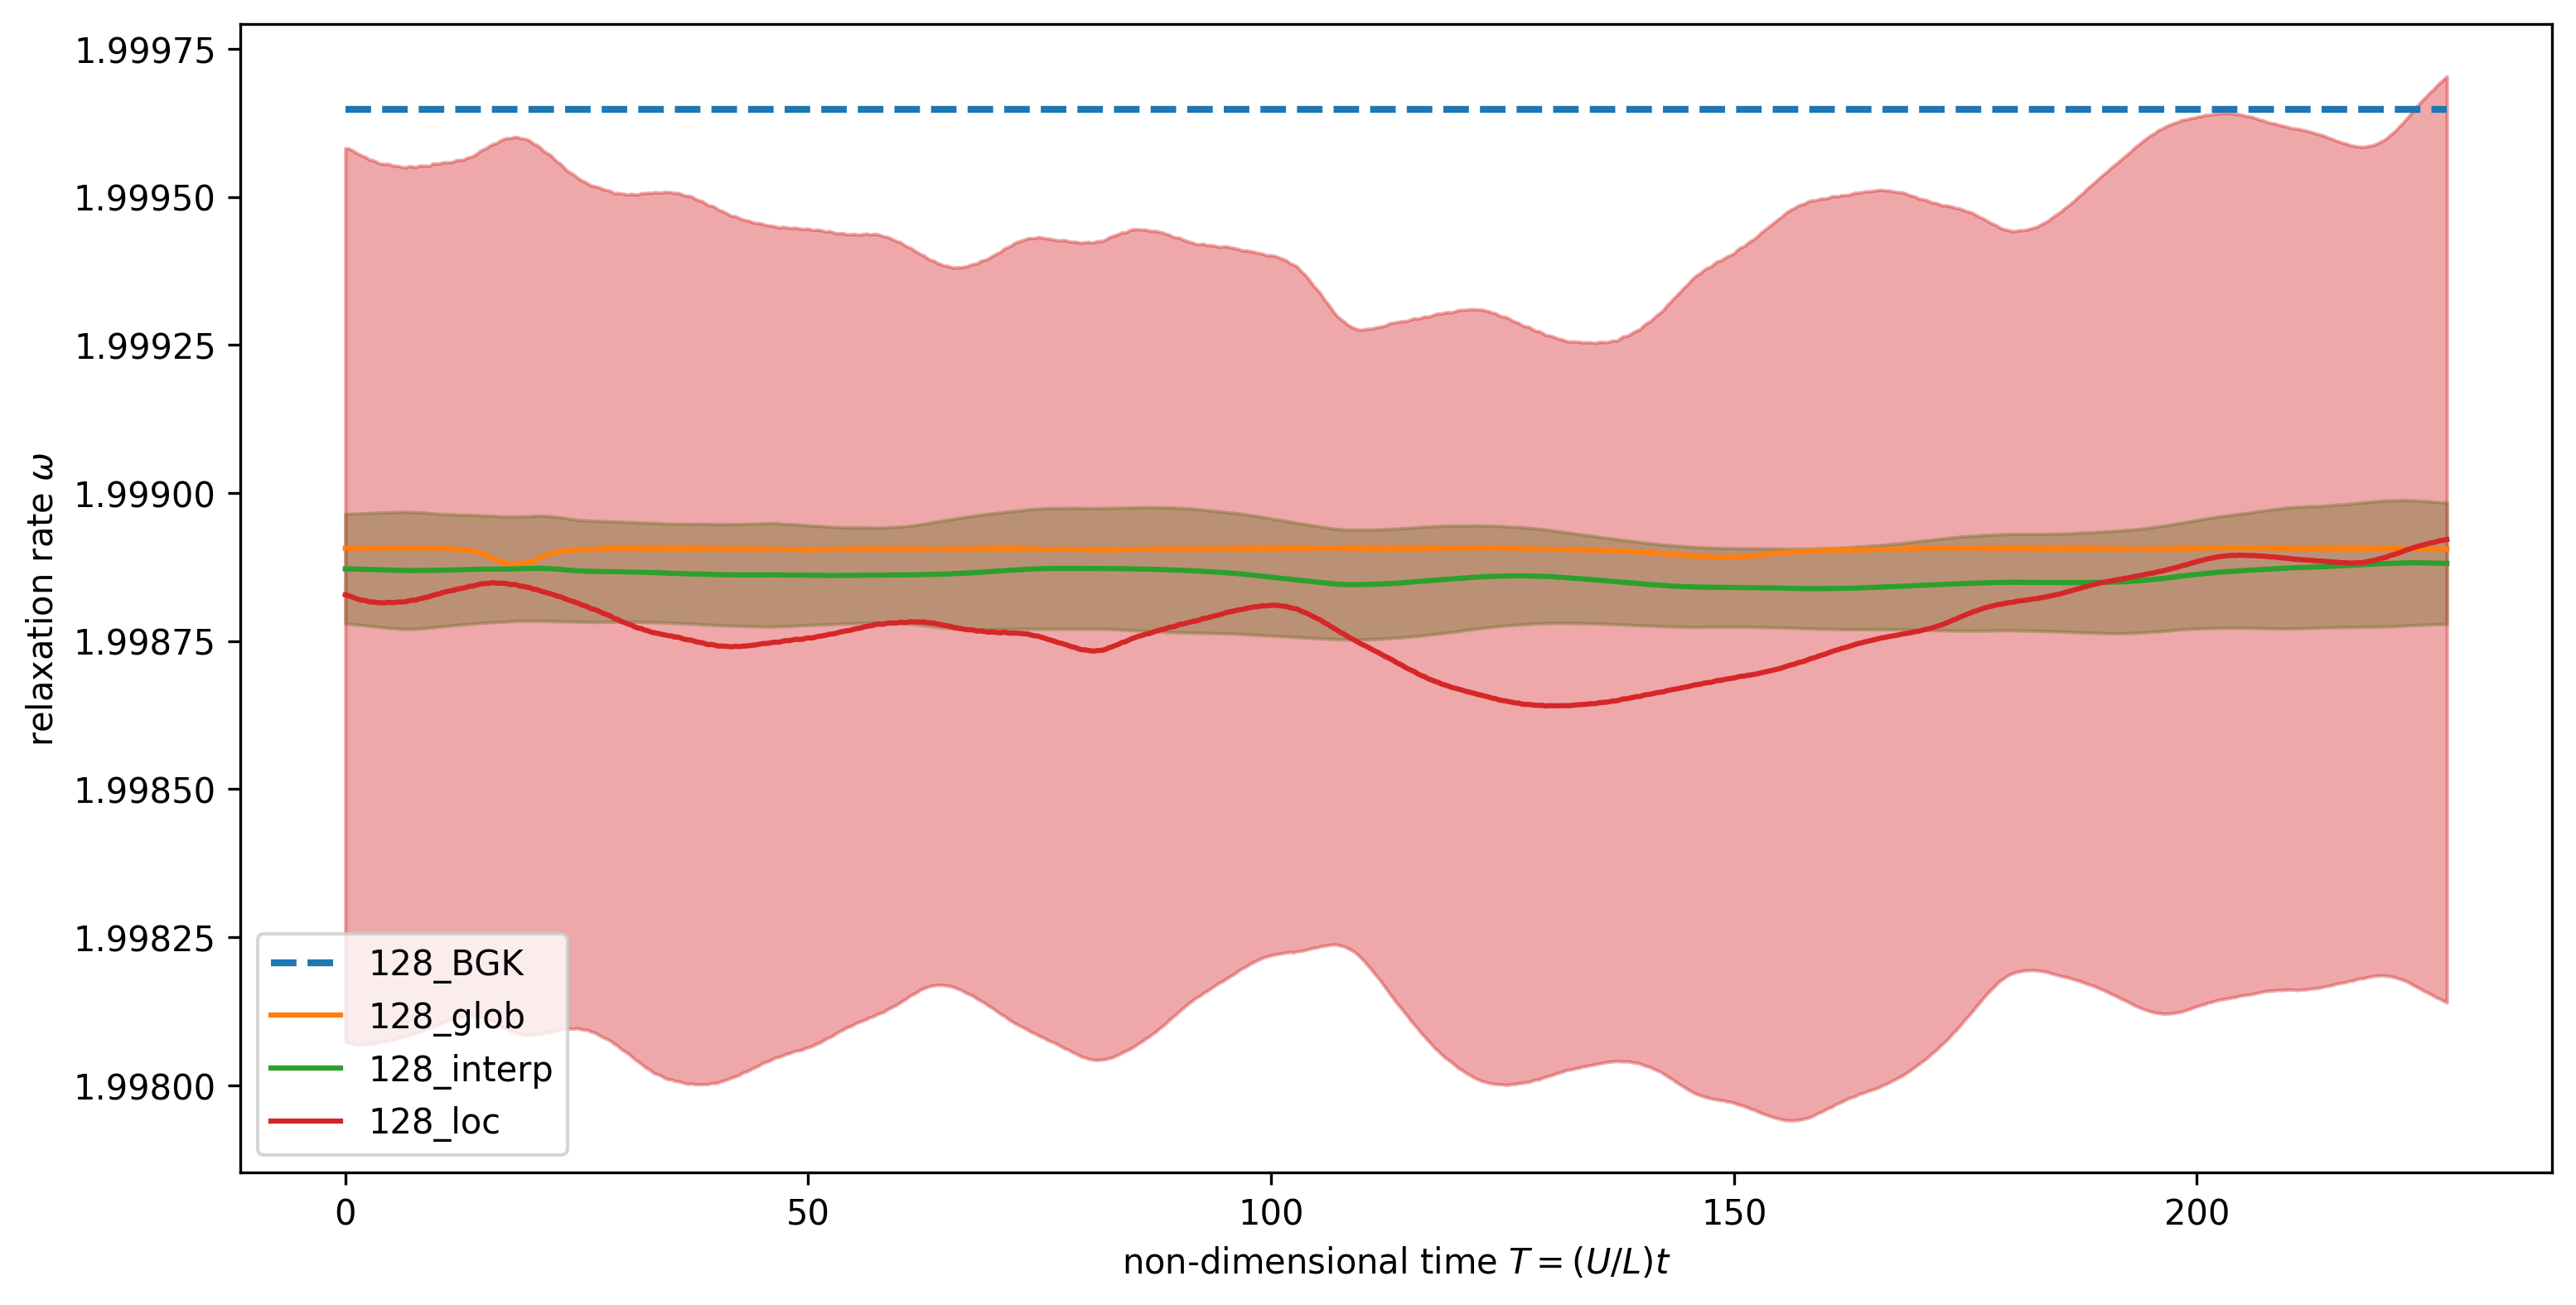

In [10]:
_,_ = test_env_glob.reset()
omg = test_env_glob.omg

relax_glob = omg * (1+np.array(a_glob))
relax_interp = omg * (1+np.array(a_interp))
relax_loc = omg * (1+np.array(a_loc))

bgk_rate = np.ones_like(relax_glob)*test_env_glob.cgs.omega
t = np.linspace(0,test_args.T, len(a_glob))

plt.figure(figsize=(12,6), dpi=300)
plt.plot(t, bgk_rate, label="128_BGK", linestyle='dashed', linewidth='2', color='#1f77b4')
plt.plot(t, relax_glob, label="128_glob", color='#ff7f0e')
plt.plot(t, relax_interp.mean(axis=(1,2)), label="128_interp", color='#2ca02c')
plt.fill_between(t,
                  relax_interp.mean(axis=(1,2))-relax_interp.std(axis=(1,2)), 
                  relax_interp.mean(axis=(1,2))+relax_interp.std(axis=(1,2)),
                    alpha=0.4, color='#2ca02c')
plt.plot(t, relax_loc.mean(axis=(1,2)), label="128_loc", color='#d62728')
plt.fill_between(t,
                  relax_loc.mean(axis=(1,2))-relax_loc.std(axis=(1,2)), 
                  relax_loc.mean(axis=(1,2))+relax_loc.std(axis=(1,2)),
                    alpha=0.4, color='#d62728')
plt.legend()
plt.xlabel(r'non-dimensional time $T = (U/L)t$')
plt.ylabel(r"relaxation rate $\omega$")
plt.show()

### for loc actions plot action visualization next to vorticity field

- maybe also plot correlation with states 

In [24]:
from matplotlib.ticker import FormatStrFormatter

def plot_policy(mean, v, act_range, i):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between plots

    # Plotting images
    im1 = axs[0].imshow(mean, cmap='viridis', aspect='equal', vmin=act_range[0], vmax=act_range[1])
    im2 = axs[1].imshow(v, cmap='icefire', vmin=-10, vmax=10)

    # Titles and ticks
    axs[0].set_title(r"Actions")
    axs[1].set_title(r"Vorticity")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[1].set_xticks([])

    # Colorbars
    cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    cbar1.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))  # Set scientific notation
    cbar1.set_ticks(np.linspace(act_range[0],act_range[1], 5))  # Example: 3 ticks

    cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
    #cbar2.set_ticks([-10, 0, 10])  # Example: 3 ticks for the second colorbar

    # Save the figure
    plt.savefig(f"figures/img_{i}.png")
    plt.close()


In [25]:
loc_range = [np.array(a_loc).mean()-np.array(a_loc).std(),
             np.array(a_loc).mean()+np.array(a_loc).std()]

In [26]:
for i in tqdm(range(len(a_loc))):
    #plot act mean, vort
    plot_policy(a_loc[i], v_loc[i], loc_range, i)

100%|██████████| 626/626 [03:08<00:00,  3.33it/s]


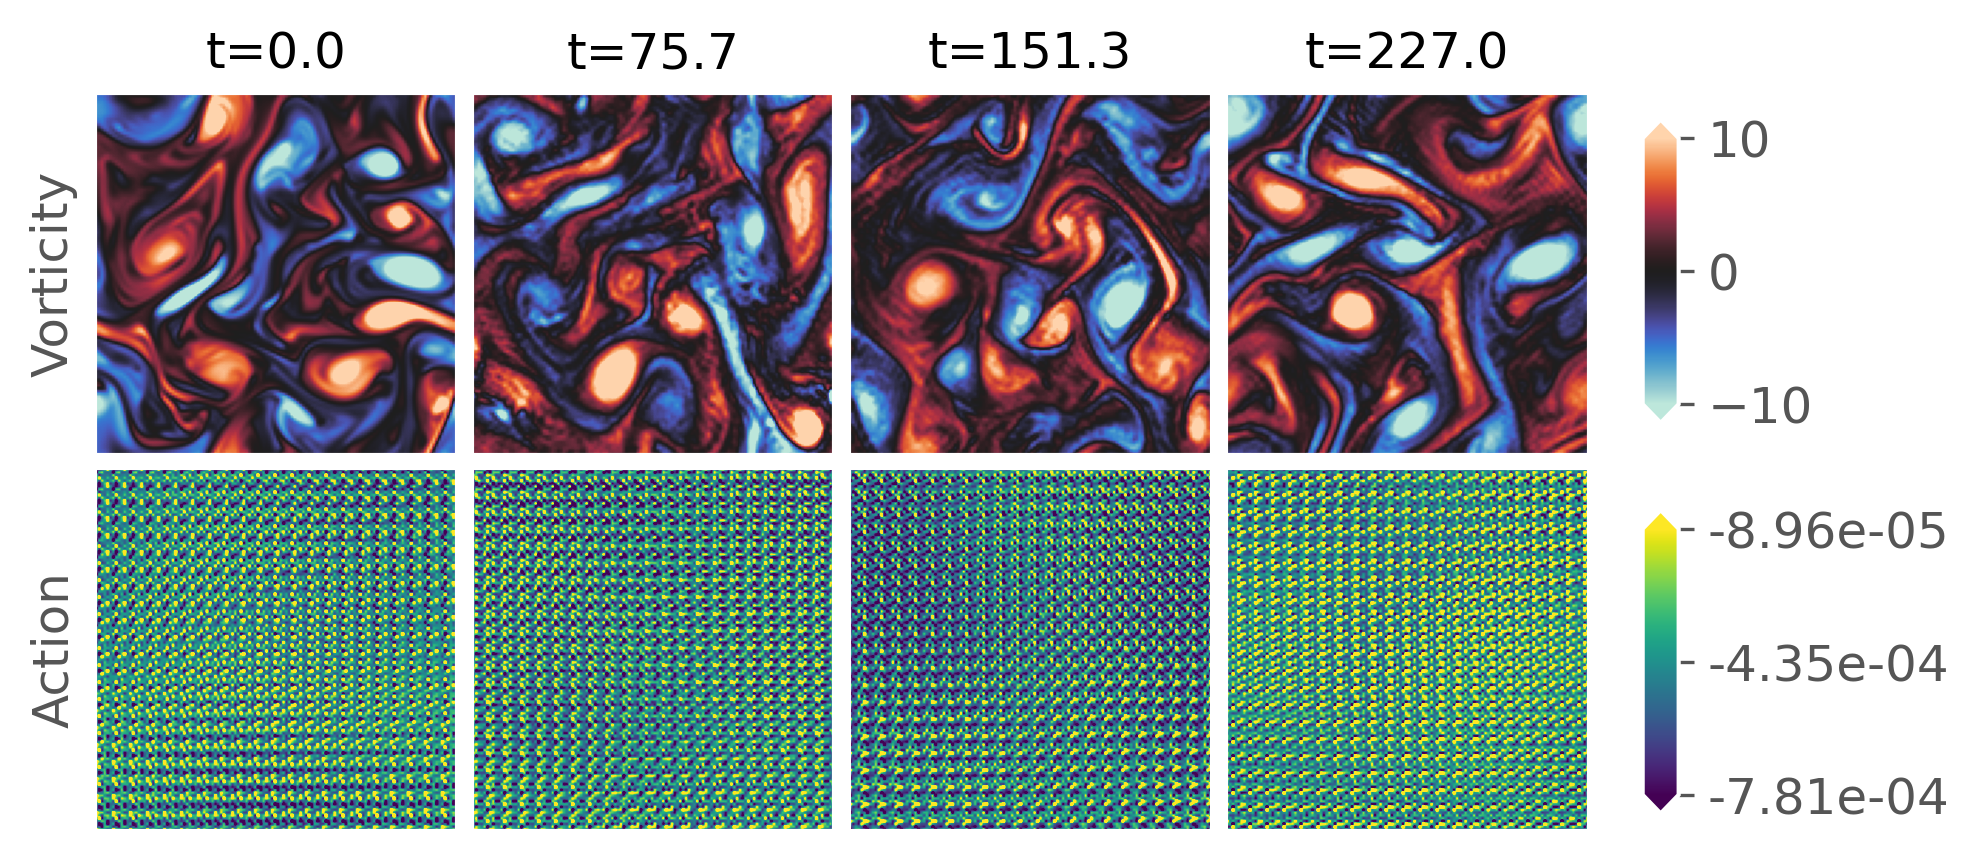

In [27]:
step = len(v_loc) // 3
fig, axs = plt.subplots(2, 4, figsize=(6., 3.1), dpi=300)
f_size = 12
label_names = ["Vorticity", "Action"]
time_labels = np.array([0, 1 / 3, 2 / 3, 1]) * 227

vmin_vorticity, vmax_vorticity = -10, 10
vmin_action, vmax_action = loc_range[0], loc_range[1]

# Plotting data
for i in range(4):
    axs[0, i].imshow(v_loc[i * step], vmin=vmin_vorticity, vmax=vmax_vorticity, cmap=sn.cm.icefire)
    axs[1, i].imshow(a_loc[i * step], vmin=vmin_action, vmax=vmax_action, cmap='viridis')
    axs[0, i].set_xticks([])  # Disable x-ticks
    axs[0, i].set_yticks([])  # Disable y-ticks
    axs[1, i].set_xticks([])  # Disable x-ticks
    axs[1, i].set_yticks([])  # Disable y-ticks

# Add row labels
for i, ax in enumerate(axs[:, 0]):
    ax.set_ylabel(label_names[i], fontsize=f_size)

# Add time labels to each column
for i, ax in enumerate(axs[0, :]):
    ax.set_title(f"t={time_labels[i]:.1f}", fontsize=f_size)

# Add colorbars with adjusted extents
image_height = axs[0, 0].get_position().height
image_width = axs[0, 0].get_position().width

# Vorticity colorbar
vorticity_cbar_ax = fig.add_axes([
    axs[0, -1].get_position().x1 + 0.01,  # Right edge of the last column + small gap
    axs[0, 0].get_position().y0,          # Match the bottom of the first row
    0.02,                                 # Fixed width for colorbar
    image_height                         # Match the height of the images
])
norm_vorticity = mcolors.Normalize(vmin=vmin_vorticity, vmax=vmax_vorticity)
sm_vorticity = plt.cm.ScalarMappable(cmap=sn.cm.icefire, norm=norm_vorticity)
cbar_vorticity = fig.colorbar(sm_vorticity, cax=vorticity_cbar_ax, extend='both', extendfrac=0.07, aspect=10)
cbar_vorticity.ax.tick_params(labelsize=f_size)
cbar_vorticity.set_ticks(np.linspace(vmin_vorticity, vmax_vorticity, 3))

# Action colorbar
action_cbar_ax = fig.add_axes([
    axs[1, -1].get_position().x1 + 0.01,  # Right edge of the last column + small gap
    axs[1, 0].get_position().y0,          # Match the bottom of the second row
    0.02,                                 # Fixed width for colorbar
    image_height                         # Match the height of the images
])
norm_action = mcolors.Normalize(vmin=vmin_action, vmax=vmax_action)
sm_action = plt.cm.ScalarMappable(cmap='viridis', norm=norm_action)
cbar_action = fig.colorbar(sm_action, cax=action_cbar_ax, extend='both', extendfrac=0.07, aspect=10)
cbar_action.ax.tick_params(labelsize=f_size)
cbar_action.set_ticks(np.linspace(vmin_action, vmax_action, 3))

# Set scientific notation for the action colorbar
cbar_action.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))

# Adjust subplot spacing to reduce whitespace
plt.subplots_adjust(left=0.05, right=0.88, top=0.9, bottom=0.1, wspace=0.04, hspace=0.02)

# Show the plot
plt.show()


### for interp actions plot action visualization next to vorticity field

- maybe also plot correlation with states 

In [28]:
def plot_policy(mean, v, act_range, i):
    
    plt.style.use('ggplot')
    fig, axs = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between plots

    # Create coordinates for 16x16 grid with padding to avoid borders
    grid_size = 16
    padding_x = mean.shape[1]//(2*16)  # 5% padding on x
    padding_y = mean.shape[0]//(2*16)  # 5% padding on y
    x = np.linspace(padding_x, mean.shape[1] - 1 - padding_x, grid_size)
    y = np.linspace(padding_y, mean.shape[0] - 1 - padding_y, grid_size)
    xx, yy = np.meshgrid(x, y)

    # Plotting images
    im1 = axs[0].imshow(mean, cmap='viridis', aspect='equal', vmin=act_range[0], vmax=act_range[1])
    im2 = axs[1].imshow(v, cmap=sn.cm.icefire, vmin=-10, vmax=10)

    # Overlay empty black circles only on axs[0]
    axs[0].scatter(xx, yy, edgecolors='black', facecolors='none', s=10, marker='o', linewidths=0.5)

    # Titles and ticks
    axs[0].set_title(r"Action")
    axs[1].set_title(r"Vorticity")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[1].set_xticks([])

    # Colorbars
    cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    cbar1.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))  # Set scientific notation
    cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    # Save the figure
    plt.savefig(f"figures/img_{i}.png")
    plt.close()

In [29]:
interp_range = [np.array(a_interp).mean()-np.array(a_interp).std(),
             np.array(a_interp).mean()+np.array(a_interp).std()]

In [30]:
for i in tqdm(range(len(a_interp))):
    #plot act mean, vort
    plot_policy(a_interp[i], v_interp[i], interp_range, i)

100%|██████████| 626/626 [03:36<00:00,  2.89it/s]


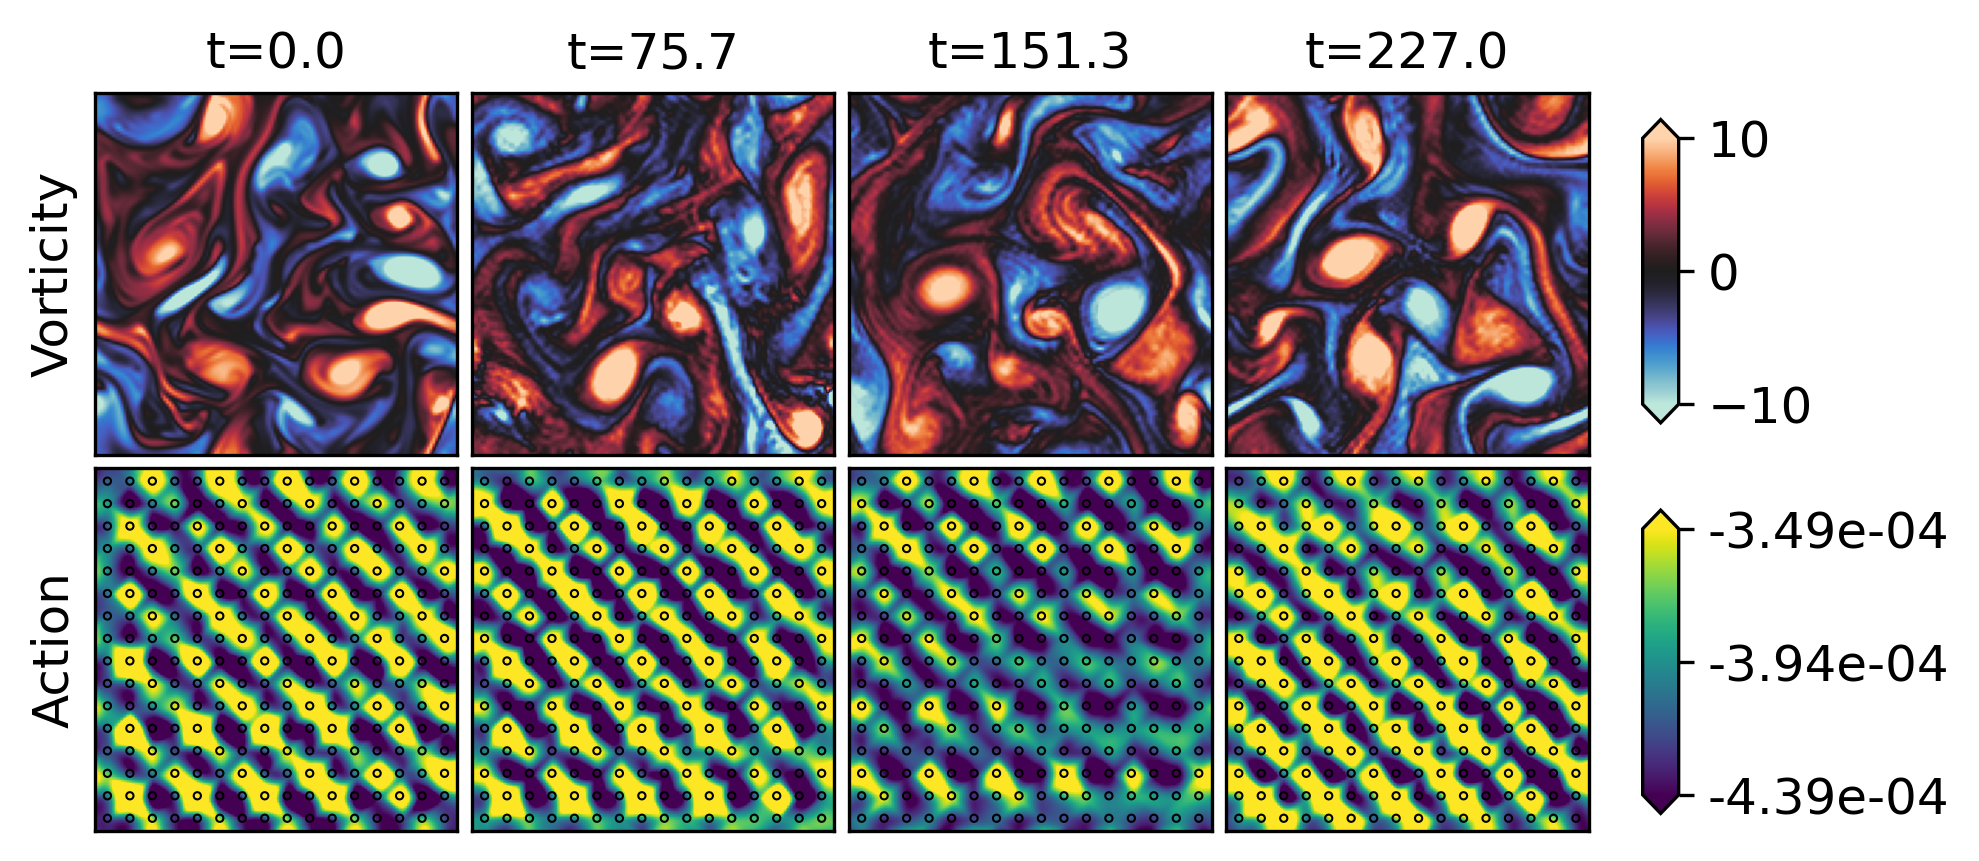

In [23]:
step = len(v_interp) // 3
fig, axs = plt.subplots(2, 4, figsize=(6., 3.1), dpi=300)
f_size = 12
label_names = ["Vorticity", "Action"]
time_labels = np.array([0, 1 / 3, 2 / 3, 1]) * 227

vmin_vorticity, vmax_vorticity = -10, 10
vmin_action, vmax_action = interp_range[0], interp_range[1]

# Plotting data
for i in range(4):
        # Create coordinates for 16x16 grid with padding to avoid borders
    grid_size = 16
    padding_x = 128//(2*16)  # 5% padding on x
    padding_y = 128//(2*16)  # 5% padding on y
    x = np.linspace(padding_x, 128 - 1 - padding_x, grid_size)
    y = np.linspace(padding_y, 128 - 1 - padding_y, grid_size)
    xx, yy = np.meshgrid(x, y)
    axs[0, i].imshow(v_interp[i * step], vmin=vmin_vorticity, vmax=vmax_vorticity, cmap=sn.cm.icefire)
    axs[1, i].imshow(a_interp[i * step], vmin=vmin_action, vmax=vmax_action, cmap='viridis')
    axs[1, i].scatter(xx, yy, edgecolors='black', facecolors='none', s=3, marker='o', linewidths=0.5)
    axs[0, i].set_xticks([])  # Disable x-ticks
    axs[0, i].set_yticks([])  # Disable y-ticks
    axs[1, i].set_xticks([])  # Disable x-ticks
    axs[1, i].set_yticks([])  # Disable y-ticks

# Add row labels
for i, ax in enumerate(axs[:, 0]):
    ax.set_ylabel(label_names[i], fontsize=f_size)

# Add time labels to each column
for i, ax in enumerate(axs[0, :]):
    ax.set_title(f"t={time_labels[i]:.1f}", fontsize=f_size)

# Add colorbars with adjusted extents
image_height = axs[0, 0].get_position().height
image_width = axs[0, 0].get_position().width

# Vorticity colorbar
vorticity_cbar_ax = fig.add_axes([
    axs[0, -1].get_position().x1 + 0.01,  # Right edge of the last column + small gap
    axs[0, 0].get_position().y0,          # Match the bottom of the first row
    0.02,                                 # Fixed width for colorbar
    image_height                         # Match the height of the images
])
norm_vorticity = mcolors.Normalize(vmin=vmin_vorticity, vmax=vmax_vorticity)
sm_vorticity = plt.cm.ScalarMappable(cmap=sn.cm.icefire, norm=norm_vorticity)
cbar_vorticity = fig.colorbar(sm_vorticity, cax=vorticity_cbar_ax, extend='both', extendfrac=0.07, aspect=10)
cbar_vorticity.ax.tick_params(labelsize=f_size)
cbar_vorticity.set_ticks(np.linspace(vmin_vorticity, vmax_vorticity, 3))

# Action colorbar
action_cbar_ax = fig.add_axes([
    axs[1, -1].get_position().x1 + 0.01,  # Right edge of the last column + small gap
    axs[1, 0].get_position().y0,          # Match the bottom of the second row
    0.02,                                 # Fixed width for colorbar
    image_height                         # Match the height of the images
])
norm_action = mcolors.Normalize(vmin=vmin_action, vmax=vmax_action)
sm_action = plt.cm.ScalarMappable(cmap='viridis', norm=norm_action)
cbar_action = fig.colorbar(sm_action, cax=action_cbar_ax, extend='both', extendfrac=0.07, aspect=10)
cbar_action.ax.tick_params(labelsize=f_size)
cbar_action.set_ticks(np.linspace(vmin_action, vmax_action, 3))

# Set scientific notation for the action colorbar
cbar_action.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))

# Adjust subplot spacing to reduce whitespace
plt.subplots_adjust(left=0.05, right=0.88, top=0.9, bottom=0.1, wspace=0.04, hspace=0.02)

# Show the plot
plt.show()
